<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features +  preprocessed_essay (TFIDF) + Sentiment scores(preprocessed_essay)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features +  preprocessed_essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)</li>        </ul> 

In [ ]:
import nltk
nltk.download('vader_lexicon')

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

<h1>1. Decision Tree </h1>

## 1.1 Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas
data = pandas.read_csv('/content/gdrive/MyDrive/Colab Notebooks/preprocessed_data.csv', nrows=10000)

In [ ]:
data.head()

school_state  ...   price
0           ca  ...  725.05
1           ut  ...  213.03
2           ca  ...  329.00
3           ga  ...  481.04
4           wa  ...   17.74

[5 rows x 9 columns]

In [ ]:
y= data['project_is_approved']
X= data.drop("project_is_approved", axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y= train_test_split(X,y, test_size=0.3,stratify= y)
train_x,cv_x,train_y,cv_y= train_test_split(train_x,train_y,test_size=0.3, stratify= train_y)

##TFIDF Vectorization

Vectorizing the Essay Variable using TFIDF Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer(min_df=10)
vectorizer.fit(train_x["essay"].values)

tr_tfidf_essay= vectorizer.transform(train_x["essay"].values)
cv_tfidf_essay= vectorizer.transform(cv_x["essay"].values)
te_tfidf_essay= vectorizer.transform(test_x["essay"].values)

Encoding Categorical features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect= CountVectorizer(min_df=10)

vect.fit(train_x["school_state"])
tr_tfidf_ss= vect.transform(train_x["school_state"].values)
cv_tfidf_ss= vect.transform(cv_x["school_state"].values)
te_tfidf_ss= vect.transform(test_x["school_state"].values)

In [ ]:
vect.fit(train_x["teacher_prefix"])
tr_tfidf_tp= vect.transform(train_x["teacher_prefix"].values)
cv_tfidf_tp= vect.transform(cv_x["teacher_prefix"].values)
te_tfidf_tp= vect.transform(test_x["teacher_prefix"].values)

In [ ]:
vect.fit(train_x["project_grade_category"])
tr_tfidf_pg= vect.transform(train_x["project_grade_category"].values)
cv_tfidf_pg= vect.transform(cv_x["project_grade_category"].values)
te_tfidf_pg= vect.transform(test_x["project_grade_category"].values)

In [ ]:
vect.fit(train_x["clean_categories"])
tr_tfidf_cc= vect.transform(train_x["clean_categories"].values)
cv_tfidf_cc= vect.transform(cv_x["clean_categories"].values)
te_tfidf_cc= vect.transform(test_x["clean_categories"].values)

In [ ]:
vect.fit(train_x["clean_subcategories"])
tr_tfidf_cs= vect.transform(train_x["clean_subcategories"].values)
cv_tfidf_cs= vect.transform(cv_x["clean_subcategories"].values)
te_tfidf_cs= vect.transform(test_x["clean_subcategories"].values)

Normalizing the Numerical Varibles using the Normalizer

In [ ]:
from sklearn.preprocessing import Normalizer
norm= Normalizer()

norm.fit(train_x["teacher_number_of_previously_posted_projects"].values.reshape(-1,1))

tr_tfidf_pp= norm.transform(train_x['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
cv_tfidf_pp= norm.transform(cv_x['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
te_tfidf_pp= norm.transform(test_x["teacher_number_of_previously_posted_projects"].values.reshape(-1,1))

In [ ]:
norm.fit(train_x["price"].values.reshape(-1,1))

tr_tfidf_price= norm.transform(train_x["price"].values.reshape(-1,1))
cv_tfidf_price= norm.transform(cv_x["price"].values.reshape(-1,1))
te_tfidf_price= norm.transform(test_x["price"].values.reshape(-1,1))

Stacking up all the features in each of the train, crossvalidation and test datasets

In [ ]:
from scipy.sparse import hstack
tr_tfidf= hstack((tr_tfidf_essay,tr_tfidf_ss,tr_tfidf_tp,tr_tfidf_pg,tr_tfidf_cc,tr_tfidf_cs,tr_tfidf_pp,tr_tfidf_price)).tocsr()
cv_tfidf= hstack((cv_tfidf_essay,cv_tfidf_ss,cv_tfidf_tp,cv_tfidf_pg,cv_tfidf_cc,cv_tfidf_cs,cv_tfidf_pp,cv_tfidf_price)).tocsr()
te_tfidf= hstack((te_tfidf_essay,te_tfidf_ss,te_tfidf_tp,te_tfidf_pg,te_tfidf_cc,te_tfidf_cs,te_tfidf_pp,te_tfidf_price)).tocsr()

In [ ]:
print(tr_tfidf.shape)
print(cv_tfidf.shape)
print(te_tfidf.shape)

(4900, 4490)
(2100, 4490)
(3000, 4490)


Iterating over different values of Depth and Sample_split Hyperparameters and finding the best hyperparameter. Using the Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

depth= [1,5,10,50] 
samples_split= [5,10,100,500]
tr_auc=[]
cv_auc=[] 

for i in tqdm(samples_split):
    for j in depth:
        model= DecisionTreeClassifier(criterion= "entropy",max_depth=j, min_samples_split=i)
        model.fit(tr_tfidf,train_y)
        tr_pred= model.predict(tr_tfidf)
        cv_pred= model.predict(cv_tfidf)

        tr_auc.append(roc_auc_score(train_y, tr_pred))
        cv_auc.append(roc_auc_score(cv_y,cv_pred))


100%|██████████| 4/4 [00:21<00:00,  5.37s/it]


In [ ]:
 print(tr_auc)
 print(cv_auc)

[0.5, 0.5299703301506187, 0.6149111305361306, 0.9347333355746817, 0.5, 0.5299703301506187, 0.6099997758651605, 0.9184597453828224, 0.5, 0.5276330240272548, 0.5711831237672584, 0.722216385377443, 0.5, 0.5036982248520709, 0.5108579321319706, 0.5741704209252286]
[0.5, 0.5035149552295676, 0.5145265764907602, 0.5164031244046485, 0.5, 0.503238712135645, 0.5101162126119261, 0.5141931796532673, 0.5, 0.5029624690417223, 0.505705848733092, 0.5201562202324252, 0.5, 0.5014478948371118, 0.4995141931796533, 0.5097066107830063]


In [ ]:
import pandas as  pd

In [ ]:
d= {"1":pd.Series([0.5, 0.5299703301506187, 0.6149111305361306, 0.9347333355746817], index=[5,10,100,500]),
    "5":pd.Series([0.5, 0.5299703301506187, 0.6099997758651605, 0.9184597453828224], index=[5,10,100,500]),
    "10":pd.Series([0.5, 0.5276330240272548, 0.5711831237672584, 0.722216385377443], index=[5,10,100,500]),
    "50":pd.Series([0.5, 0.5036982248520709, 0.5108579321319706, 0.5741704209252286], index=[5,10,100,500])}

d2= {"1":pd.Series([0.5, 0.5035149552295676, 0.5145265764907602, 0.5164031244046485], index=[5,10,100,500]),
    "5":pd.Series([0.5, 0.503238712135645, 0.5101162126119261, 0.5141931796532673], index= [5,10,100,500]),
    "10":pd.Series([0.5, 0.5029624690417223, 0.505705848733092, 0.5201562202324252], index=[5,10,100,500]),
    "50":pd.Series([0.5, 0.5014478948371118, 0.4995141931796533, 0.5097066107830063], index=[5,10,100,500])}

df1= pd.DataFrame(d)
df2= pd.DataFrame(d2)

In [ ]:
print(df1)
print(df2)

            1        5        10        50
5    0.500000  0.50000  0.500000  0.500000
10   0.529970  0.52997  0.527633  0.503698
100  0.614911  0.61000  0.571183  0.510858
500  0.934733  0.91846  0.722216  0.574170
            1         5        10        50
5    0.500000  0.500000  0.500000  0.500000
10   0.503515  0.503239  0.502962  0.501448
100  0.514527  0.510116  0.505706  0.499514
500  0.516403  0.514193  0.520156  0.509707


Plotting the Correlation Matrix between the values of Depth, Samples Split and the AUC values

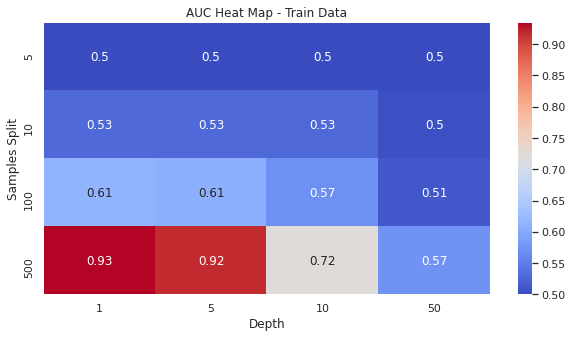

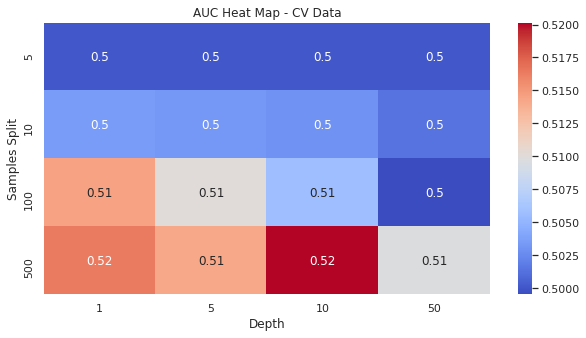

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize= (10,5))
sns.heatmap(df1,cmap="coolwarm",annot=True)
plt.title("AUC Heat Map - Train Data")
plt.ylabel("Samples Split")
plt.xlabel("Depth")
plt.show()
plt.figure(figsize= (10,5))
sns.heatmap(df2,cmap="coolwarm", annot= True)
plt.title("AUC Heat Map - CV Data")
plt.ylabel("Samples Split")
plt.xlabel("Depth")
plt.show()

Plotting the 3-D Plot between the values of Depth Samples Split and the AUC values

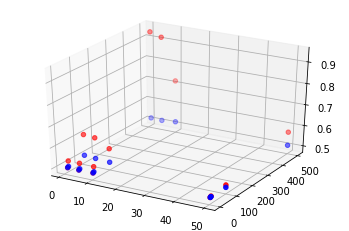

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p=[1,1,1,1,5,5,5,5,10,10,10,10,50,50,50,50]
q=[5,10,100,500,5,10,100,500,5,10,100,500,5,10,100,500]

ax.scatter(p, q,tr_auc, c='r', marker='o')
ax.scatter(p, q,cv_auc, c='b', marker='o')
plt.show()

In [ ]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np
import pandas as pd

Using a Sample_split of 50 and depth of 10

In [ ]:
fin_mod= DecisionTreeClassifier(criterion= "entropy",max_depth=10, min_samples_split=50)
fin_mod.fit(tr_tfidf,train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Predicting the values using the Best set of HyperParameters of the Decision Tree.

In [ ]:
f_tr_pred= fin_mod.predict(tr_tfidf)
f_cv_pred= fin_mod.predict(cv_tfidf)
f_te_pred= fin_mod.predict(te_tfidf)

Creating the Confusion Matrix fot the Train, Cross Validate and the Test Datasets

In [ ]:
from sklearn.metrics import confusion_matrix
tr_cfmatrix= confusion_matrix(train_y, f_tr_pred)
cv_dfmatrix= confusion_matrix(cv_y, f_cv_pred)
te_dfmatrix= confusion_matrix(test_y, f_te_pred)

Plotting the Confusion Matrix for the Train, Cross Validate and the Test Datasets

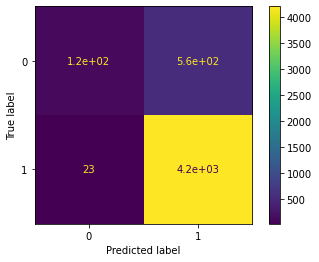

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=tr_cfmatrix, display_labels=fin_mod.classes_)
disp.plot()

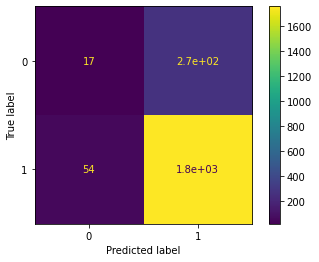

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cv_dfmatrix, display_labels=fin_mod.classes_)
disp.plot()

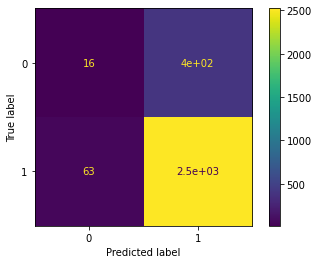

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=te_dfmatrix, display_labels=fin_mod.classes_)
disp.plot()

Plotting the ROC Curves for the Train, CrossValidate and the Test Datasets

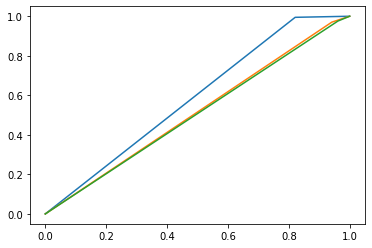

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
tr_fpr,tr_tpr,tr_tresh= roc_curve(train_y, f_tr_pred)
cv_fpr,cv_tpr,cv_tresh= roc_curve(cv_y, f_cv_pred)
te_fpr,te_tpr,te_tresh= roc_curve(test_y, f_te_pred)
plt.plot(tr_fpr,tr_tpr)
plt.plot(cv_fpr,cv_tpr)
plt.plot(te_fpr,te_tpr)
plt.show()

Estimating the AUC values for each of the Train, CrossValidate and the Test Datasets

In [ ]:
from sklearn import metrics
tr_tf_auc= metrics.auc(tr_fpr,tr_tpr)
cv_tf_auc= metrics.auc(cv_fpr,cv_tpr)
te_tf_auc= metrics.auc(te_fpr,te_tpr)

print(tr_tf_auc)
print(cv_tf_auc)
print(te_tf_auc)

0.5867745035413304
0.5143932177557631
0.5071426970196262


Plotting the WordCloud of the words of highest frequencies

In [ ]:
tfw_cloud= np.array(test_x[(test_y==0) & (f_te_pred==1)]["essay"])

100%|██████████| 398/398 [14:28<00:00,  2.18s/it]


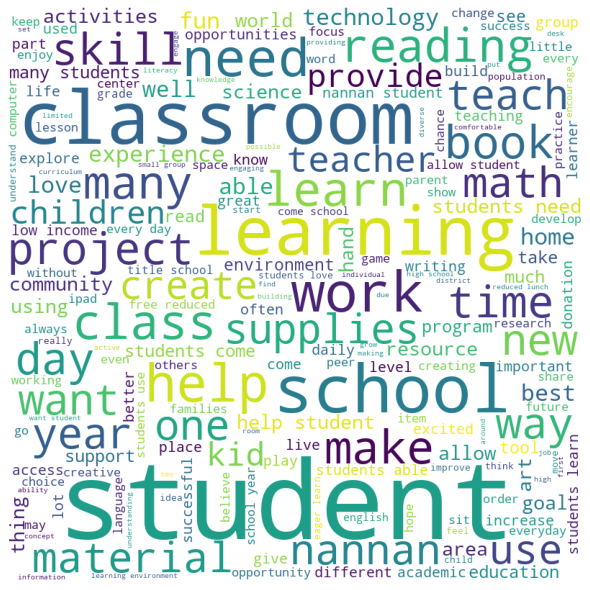

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in tqdm(tfw_cloud): 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Plotting the Box Plot of the Price Variable

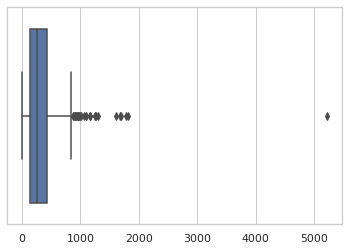

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')
sns.boxplot(x= np.array(test_x[(test_y==0) & (f_te_pred==1)]["price"]))

Plotting the PDF of the teacher_number_of_previously_posted_projects variable

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



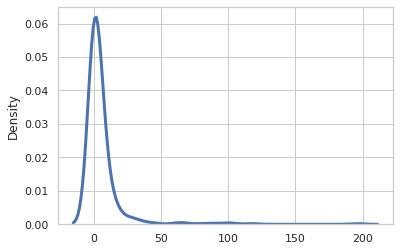

In [ ]:
sns.distplot(np.array(test_x[(test_y==0) & (f_te_pred==1)]["teacher_number_of_previously_posted_projects"]), hist = False, kde = True,
                 kde_kws = {'linewidth': 3})

Taking the Feature Importances of each of the variables

In [ ]:
f_imp= fin_mod.feature_importances_

In [ ]:
f_imp.shape

(4490,)

Converting the Sparse Matrices into DataFrames

In [ ]:
import scipy.sparse
n_tr_tfidf= pd.DataFrame.sparse.from_spmatrix(tr_tfidf)
n_cv_tfidf= pd.DataFrame.sparse.from_spmatrix(cv_tfidf)
n_te_tfidf= pd.DataFrame.sparse.from_spmatrix(te_tfidf)

In [ ]:
print(n_tr_tfidf.shape)
print(n_cv_tfidf.shape)
print(n_te_tfidf.shape)

(4900, 4490)
(2100, 4490)
(3000, 4490)


Isloating the indices of the variables with zero feature importance values

In [ ]:
ind=[]
for i in range(len(f_imp)):
  if f_imp[i]==0:
    ind.append(i)

print(len(ind))

4447


Dropping the Columns or Variables with zero Feature Importance

In [ ]:
n_tr_tfidf.drop(n_tr_tfidf.columns[ind], axis=1,inplace= True)
n_cv_tfidf.drop(n_cv_tfidf.columns[ind], axis=1,inplace= True)
n_te_tfidf.drop(n_te_tfidf.columns[ind], axis=1,inplace= True)

Using the Gridsearch to get the best hyperparameters of the Decision Tree classifier. 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
params={'min_samples_split': [5, 10, 100,500]}

clf= DecisionTreeClassifier(max_depth= None)
grid= GridSearchCV(clf,params)

grid.fit(n_tr_tfidf, train_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'min_samples_split': [5, 10, 100, 500]},
         

Getting the Best Model

In [ ]:
best_mod= grid.best_estimator_
print(best_mod)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


Fitting the best model on the Training Dataset

In [ ]:
best_mod.fit(n_tr_tfidf,train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Predicting on the train, crossvalidate and teh test datasets using the Best Model

In [ ]:
n_tr_pred= best_mod.predict(n_tr_tfidf)
n_cv_pred= best_mod.predict(n_cv_tfidf)
n_te_pred= best_mod.predict(n_te_tfidf)

Plotting the ROC curves. Logistic regression is best classifier


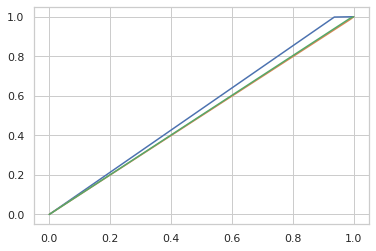

In [ ]:
n_tr_fpr,n_tr_tpr,n_tr_tresh= roc_curve(train_y, n_tr_pred)
n_cv_fpr,n_cv_tpr,n_cv_tresh= roc_curve(cv_y, n_cv_pred)
n_te_fpr,n_te_tpr,n_te_tresh= roc_curve(test_y, n_te_pred)
plt.plot(n_tr_fpr,n_tr_tpr)
plt.plot(n_cv_fpr,n_cv_tpr)
plt.plot(n_te_fpr,n_te_tpr)
plt.show()

Calculating the AUC Values for Train, CrossValidate and the Test Datasets

In [ ]:
n_tr_tf_auc= metrics.auc(n_tr_fpr,n_tr_tpr)
n_cv_tf_auc= metrics.auc(n_cv_fpr,n_cv_tpr)
n_te_tf_auc= metrics.auc(n_te_fpr,n_te_tpr)

print(n_tr_tf_auc)
print(n_cv_tf_auc)
print(n_te_tf_auc)

0.5309761352429622
0.49881882263288246
0.5019783225170091


Using Different classifiers such as Logistic and the SVM. Using SGDClassifier to find the best classifier and other HyperParameters

In [ ]:
from sklearn.linear_model import SGDClassifier
clf2= SGDClassifier()
params2= {"loss":["log","hinge"],"alpha":[0.0001, 0.001, 0.01, 0.1],"penalty":["l2","l1"]}

grid2= GridSearchCV(clf2,param_grid= params2)


Fitting the model on the Traning Datasets

In [ ]:
grid2.fit(n_tr_tfidf,train_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['log', 'hinge'], 'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_scor

Getting the Best Model with the best hyperparameters


In [ ]:
best_mod2= grid2.best_estimator_
print(best_mod2)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


Fitting the best model on the Training Data

In [ ]:
best_mod2.fit(n_tr_tfidf,train_y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Predicting on Train,CrossValidate and the Test Datasets using the best model

In [ ]:
n2_tr_pred= best_mod2.predict(n_tr_tfidf)
n2_cv_pred= best_mod2.predict(n_cv_tfidf)
n2_te_pred= best_mod2.predict(n_te_tfidf)

Plotting the ROC Curve using the Best Model(SVM)

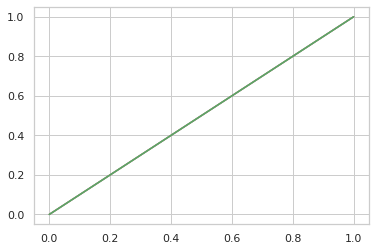

In [ ]:
n2_tr_fpr,n2_tr_tpr,n2_tr_tresh= roc_curve(train_y, n2_tr_pred)
n2_cv_fpr,n2_cv_tpr,n2_cv_tresh= roc_curve(cv_y, n2_cv_pred)
n2_te_fpr,n2_te_tpr,n2_te_tresh= roc_curve(test_y, n2_te_pred)
plt.plot(n2_tr_fpr,n2_tr_tpr)
plt.plot(n2_cv_fpr,n2_cv_tpr)
plt.plot(n2_te_fpr,n2_te_tpr)
plt.show()

Estimating the AUC vavlues for each of Train, CrossValidate and the Test Datasets

In [ ]:
n2_tr_tf_auc= metrics.auc(n2_tr_fpr,n2_tr_tpr)
n2_cv_tf_auc= metrics.auc(n2_cv_fpr,n2_cv_tpr)
n2_te_tf_auc= metrics.auc(n2_te_fpr,n2_te_tpr)

print(n2_tr_tf_auc)
print(n2_cv_tf_auc)
print(n2_te_tf_auc)

0.5309761352429622
0.49881882263288246
0.5019783225170091


Getting the Confusion Matrices for each of the Train, CrossValidate and the Test Datasets

In [ ]:
n_tr_cfmatrix= confusion_matrix(train_y, n_tr_pred)
n_cv_dfmatrix= confusion_matrix(cv_y, n_cv_pred)
n_te_dfmatrix= confusion_matrix(test_y, n_te_pred)

Plotting the Confusion Matrices for each of the Train, CrossValidate and the Test Datasets

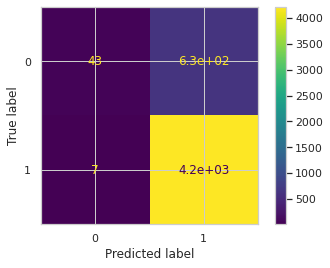

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=n_tr_cfmatrix, display_labels=best_mod.classes_)
disp.plot()

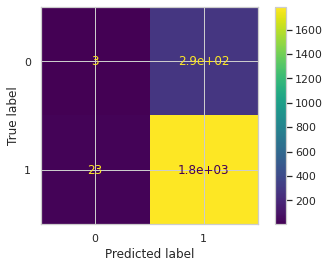

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=n_cv_dfmatrix, display_labels=best_mod.classes_)
disp.plot()

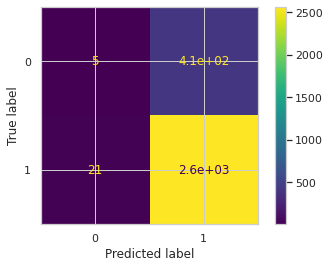

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=n_te_dfmatrix, display_labels=best_mod.classes_)
disp.plot()

##Word2Vev (TfIdf)

In [ ]:
#https://jovian.ai/sdhilip/copy-of-recommendation-word2vec-1/v/1?utm_source=embed

In [ ]:
tr_essay= train_x["essay"].values
cv_essay= cv_x["essay"].values
te_essay= test_x["essay"].values

Downloading the Glove Vectors

In [ ]:
pip install -U gensim

     |████████████████████████████████| 24.2MB 1.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

In [ ]:
tr_corpus=[]
cv_corpus=[]
te_corpus=[]

for i in tr_essay:
  tr_corpus.append(i.split())

for j in cv_essay:
  cv_corpus.append(j.split())

for k in te_essay:
  te_corpus.append(k.split())

In [ ]:
#Code Credit: https://jovian.ai/sdhilip/copy-of-recommendation-word2vec-1/v/1?utm_source=embed
# Downloading the Google pretrained Word2Vec Model
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)


--2021-01-04 02:39:34--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.107.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.107.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  47.6MB/s    in 34s     

2021-01-04 02:40:08 (46.3 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



Fitting the W2V Model on the Corpus

In [ ]:
#Code Credits:https://jovian.ai/sdhilip/copy-of-recommendation-word2vec-1/v/1?utm_source=embed
# Training our corpus with Google Pretrained Model

google_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
google_model.build_vocab(tr_corpus)

#model.intersect_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

google_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

google_model.train(tr_corpus, total_examples=google_model.corpus_count, epochs = 5)

(0, 0)

Fitting the W2V model on each of the Train, Crossvalidate and the Test Datasets

In [ ]:
vectorizer.fit(tr_essay)
tr_dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tr_tfidf_words = set(vectorizer.get_feature_names())

In [ ]:
vectorizer.fit(cv_essay)
cv_dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
cv_tfidf_words = set(vectorizer.get_feature_names())

In [ ]:
vectorizer.fit(te_essay)
te_dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
te_tfidf_words = set(vectorizer.get_feature_names())

Getting the Vectors for each of the words in the training dataset (Essay Variable)

In [ ]:
tr_tfidf_w2v_vectors= []

for line in tqdm(tr_essay):
        tr_vector = np.zeros(300)
        tr_tf_idf_weight =0
        for word in line.split():
            if (word in google_model.wv.vocab) and (word in tr_tfidf_words):
                tr_vec= google_model[word]
                tr_tf_idf = tr_dictionary[word]*(line.count(word)/len(line.split())) # getting the tfidf value for each word
                tr_vector += (tr_vec * tr_tf_idf) # calculating tfidf weighted w2v
                tr_tf_idf_weight += tr_tf_idf
        if tr_tf_idf_weight != 0:
            tr_vector /= tr_tf_idf_weight
        tr_tfidf_w2v_vectors.append(tr_vector)

print(len(tr_tfidf_w2v_vectors))
print(len(tr_tfidf_w2v_vectors[0]))

  0%|          | 0/4900 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

100%|██████████| 4900/4900 [00:25<00:00, 193.98it/s]

4900
300


Getting the Vectors for each of the words in the CrossValiation dataset (Essay Variable)

In [ ]:
cv_tfidf_w2v_vectors= []

for line in tqdm(cv_essay):
        cv_vector = np.zeros(300)
        cv_tf_idf_weight =0
        for word in line.split():
            if (word in google_model.wv.vocab) and (word in cv_tfidf_words):
                cv_vec= google_model[word]
                cv_tf_idf = cv_dictionary[word]*(line.count(word)/len(line.split())) # getting the tfidf value for each word
                cv_vector += (cv_vec * cv_tf_idf) # calculating tfidf weighted w2v
                cv_tf_idf_weight += cv_tf_idf
        if cv_tf_idf_weight != 0:
            cv_vector /= cv_tf_idf_weight
        cv_tfidf_w2v_vectors.append(cv_vector)

print(len(cv_tfidf_w2v_vectors))
print(len(cv_tfidf_w2v_vectors[0]))

  0%|          | 0/2100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

100%|██████████| 2100/2100 [00:10<00:00, 203.69it/s]

2100
300


Getting the Vectors for each of the words in the Test dataset (Essay Variable)

In [ ]:
te_tfidf_w2v_vectors= []

for line in tqdm(te_essay):
        te_vector = np.zeros(300)
        te_tf_idf_weight =0
        for word in line.split():
            if (word in google_model.wv.vocab) and (word in te_tfidf_words):
                te_vec= google_model[word]
                te_tf_idf = te_dictionary[word]*(line.count(word)/len(line.split())) # getting the tfidf value for each word
                te_vector += (te_vec * te_tf_idf) # calculating tfidf weighted w2v
                te_tf_idf_weight += te_tf_idf
        if te_tf_idf_weight != 0:
            te_vector /= te_tf_idf_weight
        te_tfidf_w2v_vectors.append(te_vector)

print(len(te_tfidf_w2v_vectors))
print(len(te_tfidf_w2v_vectors[0]))

  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

100%|██████████| 3000/3000 [00:14<00:00, 212.09it/s]

3000
300


Stacking up all the features and creating the W2V (Set 2) datasets for each of Training, CrossValidation and the Test Datasets

In [ ]:
tr_w2v= hstack((np.array(tr_tfidf_w2v_vectors),tr_tfidf_ss,tr_tfidf_tp,tr_tfidf_pg,tr_tfidf_cc,tr_tfidf_cs,tr_tfidf_pp,tr_tfidf_price)).tocsr()
cv_w2v= hstack((np.array(cv_tfidf_w2v_vectors),cv_tfidf_ss,cv_tfidf_tp,cv_tfidf_pg,cv_tfidf_cc,cv_tfidf_cs,cv_tfidf_pp,cv_tfidf_price)).tocsr()
te_w2v= hstack((np.array(te_tfidf_w2v_vectors),te_tfidf_ss,te_tfidf_tp,te_tfidf_pg,te_tfidf_cc,te_tfidf_cs,te_tfidf_pp,te_tfidf_price)).tocsr()

Running the Decision Tree classifier on various values of Depth and the samples_split hyperparameters

In [ ]:
depth= [1,5,10,50] 
samples_split= [5,10,100,500]
w2v_tr_auc=[]
w2v_cv_auc=[] 

for i in tqdm(samples_split):
    for j in depth:
        model= DecisionTreeClassifier(criterion= "entropy",max_depth=j, min_samples_split=i)
        model.fit(tr_w2v,train_y)
        tr_pred= model.predict(tr_w2v)
        cv_pred= model.predict(cv_w2v)

        w2v_tr_auc.append(roc_auc_score(train_y, tr_pred))
        w2v_cv_auc.append(roc_auc_score(cv_y,cv_pred))

100%|██████████| 4/4 [00:35<00:00,  8.75s/it]


In [ ]:
 print(w2v_tr_auc)
 print(w2v_cv_auc)

[0.5, 0.5191712334140219, 0.8195546440738749, 0.9968635130894746, 0.5, 0.5190528622019006, 0.8115068024923794, 0.9714480231307154, 0.5, 0.5050591435807782, 0.5978089418594226, 0.6163589015151515, 0.5, 0.5, 0.5, 0.5026034662452932]
[0.5, 0.5070965898266337, 0.520956372642408, 0.5394075061916556, 0.5, 0.5059916174509431, 0.5200609639931415, 0.5412650028576872, 0.5, 0.4988950276243094, 0.5014859973328253, 0.5039626595542008, 0.5, 0.5, 0.5, 0.49917127071823203]


In [ ]:
w_d= {"1":pd.Series([0.5, 0.5191712334140219, 0.8195546440738749, 0.9968635130894746], index=[5,10,100,500]),
    "5":pd.Series([0.5, 0.5190528622019006, 0.8115068024923794, 0.9714480231307154], index=[5,10,100,500]),
    "10":pd.Series([0.5, 0.5050591435807782, 0.5978089418594226, 0.6163589015151515], index=[5,10,100,500]),
    "50":pd.Series([0.5, 0.5, 0.5, 0.5026034662452932], index=[5,10,100,500])}

w_d2= {"1":pd.Series([0.5, 0.5070965898266337, 0.520956372642408, 0.5394075061916556], index=[5,10,100,500]),
    "5":pd.Series([0.5, 0.5059916174509431, 0.5200609639931415, 0.5412650028576872], index= [5,10,100,500]),
    "10":pd.Series([0.5, 0.4988950276243094, 0.5014859973328253, 0.5039626595542008], index=[5,10,100,500]),
    "50":pd.Series([0.5, 0.5, 0.5, 0.49917127071823203], index=[5,10,100,500])}

w2v_df1= pd.DataFrame(w_d)
w2v_df2= pd.DataFrame(w_d2)

Plotting the Heatmap with Depth, sample_split and the AUC parameters

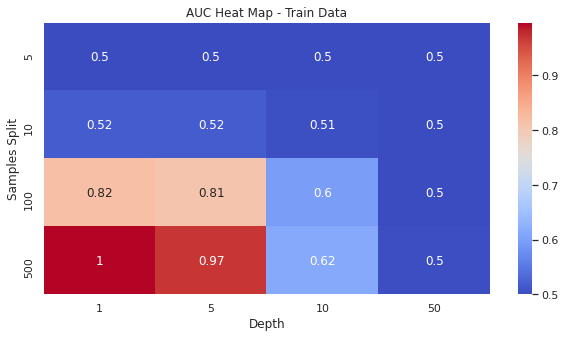

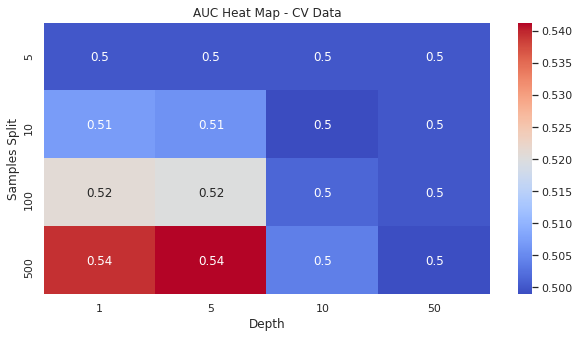

In [ ]:
plt.figure(figsize= (10,5))
sns.heatmap(w2v_df1,cmap="coolwarm",annot=True)
plt.title("AUC Heat Map - Train Data")
plt.ylabel("Samples Split")
plt.xlabel("Depth")
plt.show()
plt.figure(figsize= (10,5))
sns.heatmap(w2v_df2,cmap="coolwarm", annot= True)
plt.title("AUC Heat Map - CV Data")
plt.ylabel("Samples Split")
plt.xlabel("Depth")
plt.show()

Fitting the Decision Tree Classifier with best HyperParameter values of Depth=10 and Minimum Split_samples=5.

In [ ]:
w2v_fin_mod= DecisionTreeClassifier(criterion= "entropy",max_depth=10, min_samples_split=5)
w2v_fin_mod.fit(tr_w2v,train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Predicting the train,crossvalidate and the test values using the best model 

In [ ]:
w2v_tr_pred= w2v_fin_mod.predict(tr_w2v)
w2v_cv_pred= w2v_fin_mod.predict(cv_w2v)
w2v_te_pred= w2v_fin_mod.predict(te_w2v)

In [ ]:
print(np.unique(w2v_tr_pred))
print(np.unique(w2v_cv_pred))
print(np.unique(w2v_te_pred))
print(np.unique(train_y))

[0 1]
[0 1]
[0 1]
[0 1]


In [ ]:
print(len(np.unique(w2v_te_pred)))

2


In [ ]:
#tresh= [0.4,0.5,0.6,0.7,0.8]
#preds= []
#for t in tqdm(tresh):
  #for p in range(len(w2v_te_pred)):
    #if w2v_te_pred[p]>=t:
      #w2v_te_pred[p]=1
    #else:
      #w2v_te_pred[p]=0
  #preds.append(w2v_te_pred)

In [ ]:
#np.unique(preds[0])

In [ ]:
#for l in range(len(preds)):
    #w2v_te_cfmatrix= confusion_matrix(test_y, preds[l])
    #w2v_te_disp = ConfusionMatrixDisplay(confusion_matrix=w2v_te_cfmatrix, display_labels=w2v_fin_mod.classes_)
    #w2v_te_disp.plot()

Plotting the ROC curves for each of the Train,CrossValidate and the Test Datasets

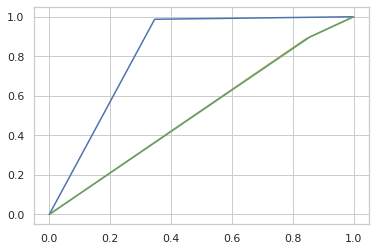

In [ ]:
w2v_tr_fpr,w2v_tr_tpr,w2v_tr_tresh= roc_curve(train_y, w2v_tr_pred)
w2v_cv_fpr,w2v_cv_tpr,w2v_cv_tresh= roc_curve(cv_y, w2v_cv_pred)
w2v_te_fpr,w2v_te_tpr,w2v_te_tresh= roc_curve(test_y, w2v_te_pred)
plt.plot(w2v_tr_fpr,w2v_tr_tpr)
plt.plot(w2v_cv_fpr,w2v_cv_tpr)
plt.plot(w2v_te_fpr,w2v_te_tpr)
plt.show()

Estimating the AUC Values Corresponding to the best Model

In [ ]:
w2v_tr_tf_auc= metrics.auc(w2v_tr_fpr,w2v_tr_tpr)
w2v_cv_tf_auc= metrics.auc(w2v_cv_fpr,w2v_cv_tpr)
w2v_te_tf_auc= metrics.auc(w2v_te_fpr,w2v_te_tpr)

print(w2v_tr_tf_auc)
print(w2v_cv_tf_auc)
print(w2v_te_tf_auc)

0.8205310314685316
0.5223375881120212
0.5205986527231357


In [ ]:
w2v_cv_tresh

array([2, 1, 0])

Getting the Confusion Matrix for each of the Train CV and Test datasets and the plotting the same

In [ ]:
w2v_tr_cfmatrix= confusion_matrix(train_y, w2v_tr_pred)
w2v_cv_cfmatrix= confusion_matrix(cv_y, w2v_cv_pred)
w2v_te_cfmatrix= confusion_matrix(test_y, w2v_te_pred)

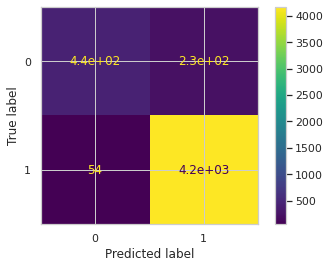

In [ ]:
w2v_tr_disp = ConfusionMatrixDisplay(confusion_matrix=w2v_tr_cfmatrix, display_labels=w2v_fin_mod.classes_)
w2v_tr_disp.plot()

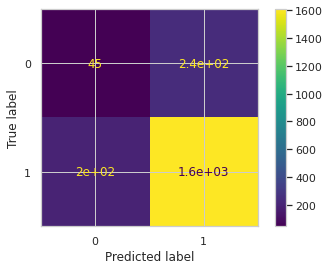

In [ ]:
w2v_cv_disp = ConfusionMatrixDisplay(confusion_matrix=w2v_cv_cfmatrix, display_labels=w2v_fin_mod.classes_)
w2v_cv_disp.plot()

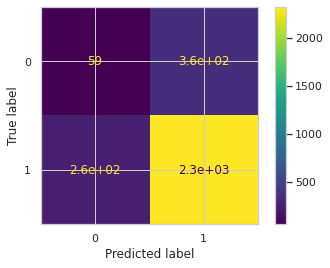

In [ ]:
w2v_te_disp = ConfusionMatrixDisplay(confusion_matrix=w2v_te_cfmatrix, display_labels=w2v_fin_mod.classes_)
w2v_te_disp.plot()

Getting the words for the WordCloud

In [ ]:
w_cloud= np.array(test_x[(test_y==0) & (w2v_te_pred==1)]["essay"])

In [ ]:
w_cloud.shape

(355,)

Plotting the Word Cloud

100%|██████████| 355/355 [12:42<00:00,  2.15s/it]


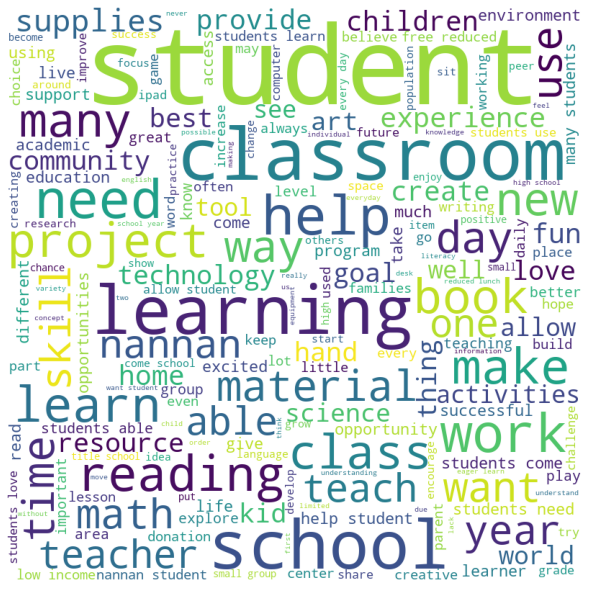

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in tqdm(w_cloud): 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Plotting the BoxPlot for the Price Variable

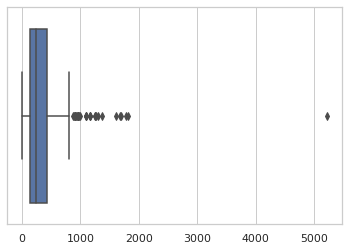

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')
sns.boxplot(x= np.array(test_x[(test_y==0) & (w2v_te_pred==1)]["price"]))

Plotting the PDF for the teacher_number_of_previously_posted_projects variable

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



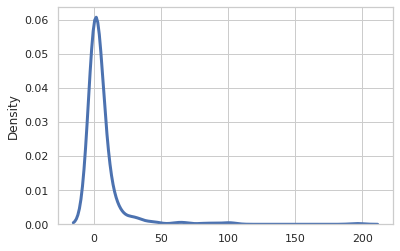

In [ ]:
sns.distplot(np.array(test_x[(test_y==0) & (w2v_te_pred==1)]["teacher_number_of_previously_posted_projects"]), hist = False, kde = True,
                 kde_kws = {'linewidth': 3})